# 네이버 영화리뷰 감성분석 - 딥러닝을 위한 전처리 RNN
## tensorflow 2.0 설치
- Requires the latest pip  
pip install --upgrade pip
- Current stable release for CPU and GPU  
pip install tensorflow
- Or try the preview build (unstable)  
pip install tf-nightly

In [1]:
# tensorflow가 없는 경우 아래의 코드로 설치한다.

#pip install --upgrade pip
#pip install tensorflow
#pip install tf-nightly

In [2]:
# 코렙 tensorflow 실행
# %tensorflow_version 2.0

# 코렙 mecab 설치 

#!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
#!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
#!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
#!sudo apt-get install curl
#!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
from konlpy.tag import Mecab
m = Mecab()
m.nouns('메캡이 잘 실행 될까요?')

['메', '캡', '실행']

1. 네이버 영화리뷰 데이터 읽기
2. 데이터 정제(이모티콘, 영문, 숫자, ... 삭제)
3. 토큰화(mecab) - 불용처리, 1글자 제거.
4. RNN 모델을 학습 시킬 수 있는 형태로 변경
5. RNN 학습
6. 학습된 모델로 test 데이터 예측

## 데이터 호출

In [26]:
import pandas as pd
import numpy as np

train = pd.DataFrame(pd.read_csv('ratings_train.txt', sep='\t', quoting=3))
train = train.replace(np.nan, '', regex=True)
test = pd.DataFrame(pd.read_csv('ratings_test.txt', sep='\t', quoting=3))
test = test.replace(np.nan, '', regex=True)
print('train :',len(train))
print('test :',len(test))

train : 150000
test : 50000


## 데이터 전처리와 토큰화

In [27]:
import re 
# '한글'을 제외한 다른 문자 모두 제거
remove_except_ko = re.compile(r"[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]")
def preprocess(text):
    text = re.sub(remove_except_ko,' ',text).strip()
    return text

train['document'] = train['document'].map(lambda x : preprocess(x))
test['document']=test['document'].map(lambda x : preprocess(x))

In [28]:
from konlpy.tag import Mecab
mecab = Mecab()
# mecab을 사용해서 토큰화, 한글자 제거, stop_word 제거 

stop_word = ['께서','에서','이다','에게','으로','이랑','까지','부터','하다']
#stopPos = ['JKS','JKC','JKG','JKO','JKB','JKV','JKQ','JC','JX',
#           'SF','SE','SS','SP','SSO','SSC','SC','SY','SH','SL','SN',
#           'MM','MAG','MAJ']

def postagging_mecab(text):
    text = mecab.morphs(text)
    text = [i for i in text if len(i)>1]
    text = [i for i in text if i not in stop_word]
    return text

In [30]:
# 토큰화 + 토큰리스트 생성 
def make_tokens(df):
    df['tokens'] = ''
    tokens_list=[]
    for i, row in df.iterrows():
        if i%10000==0:
            print(i,'/',len(df))
        token = postagging_mecab(df['document'][i])
        tokens_list.append(token)
        df['tokens'][i] = token
    return tokens_list, df

test_list, test = make_tokens(test)

0 / 50000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000


In [35]:
test.head()

,id,document,label,tokens
0,6270596,굳 ㅋ,1,[]
1,9274899,,0,[]
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0,"[평점, 나쁘, 지만, 짜리, 더더욱, 아니, 잖아]"
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"[지루, 은데, 완전, 막장]"
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0,"[아니, 어도, 다섯, 텐데, 나와서, 심기, 불편]"


In [36]:
train_list, train = make_tokens(train)

0 / 150000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


10000 / 150000
20000 / 150000
30000 / 150000
40000 / 150000
50000 / 150000
60000 / 150000
70000 / 150000
80000 / 150000
90000 / 150000
100000 / 150000
110000 / 150000
120000 / 150000
130000 / 150000
140000 / 150000


In [37]:
train.head()

,id,document,label,tokens
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[진짜, 짜증, 네요, 목소리]"
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1,"[포스터, 보고, 초딩, 영화, 오버, 연기, 조차, 가볍, 구나]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너무, 밓었다그래서보는것을추천한다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0,"[교도소, 이야기, 구먼, 솔직히, 재미, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이몬페그, 익살, 스런, 연기, 돋보였, 영화, 스파이더맨, 보이, 커스틴, 던..."


## 토큰화된 단어 벡터화
```python
from tensorflow.keras.preprocessing.text import Tokenizer
```
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
> This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...
tf-idf를 기반으로 단어를 백터화

```python
from tensorflow.keras.preprocessing.sequence import pad_sequences
```
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
# make train word set  
tokenizer.fit_on_texts(train_list)

In [42]:
#4만 6979개의 word set 
print(len(tokenizer.word_index))

46979


In [43]:
#단어를 숫자배열로 변환 
X_train_arrary_list = tokenizer.texts_to_sequences(train_list)
X_test_arrary_list = tokenizer.texts_to_sequences(test_list)
X_train = X_train_arrary_list
X_test = X_test_arrary_list
# 레이블링 데이터 행렬변환
Y_train = np.array(train['label'])
Y_test = np.array(test['label'])
print('훈련데이터 : ',len(X_train_arrary_list))

훈련데이터 :  150000


In [44]:
# 확인
print(train_list[:7])
print('-'*50)
print(X_train_arrary_list[:7])

[['진짜', '짜증', '네요', '목소리'], ['포스터', '보고', '초딩', '영화', '오버', '연기', '조차', '가볍', '구나'], ['너무', '밓었다그래서보는것을추천한다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '평점', '조정'], ['사이몬페그', '익살', '스런', '연기', '돋보였', '영화', '스파이더맨', '보이', '커스틴', '던스트', '너무나', '이뻐', '보였'], ['걸음마', '초등', '학교', '학년', '살용', '영화', 'ㅋㅋㅋ', '별반', '아까움'], ['원작', '긴장감', '제대로', '살려', '못했']]
--------------------------------------------------
[[8, 105, 5, 449], [294, 304, 411, 1, 1126, 10, 575, 636, 206], [3, 26782], [6972, 64, 3387, 142, 28, 12, 2638], [20051, 7396, 713, 10, 2102, 1, 2029, 177, 13946, 20052, 232, 2314, 1221], [20053, 1041, 430, 1167, 26783, 1, 17, 1614, 461], [121, 196, 200, 1422, 511]]


리뷰의 최대 길이 : 65
리뷰의 평균 길이 : 7.4033066666666665


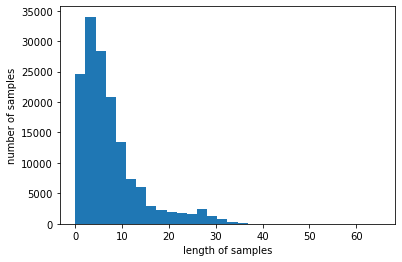

In [45]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [46]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.126


In [47]:
# 데이터 길이 30으로 패딩 
max_len = 30
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## LSTM을 사용한 감성분석

In [48]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [49]:
vocab_size = len(X_train)
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [50]:

# 검증 데이터 손실(val_loss)이 증가하면, 과적합이 될수 있기 때문에 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping). 
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('naver_movie_model_lstm', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [51]:
# generate model 
# loss = 'sparse_categorical_crossentropy' # 분류모델사용 
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.4279 - acc: 0.7946
Epoch 00001: val_acc improved from -inf to 0.81613, saving model to naver_movie_model_lstm
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: naver_movie_model_lstm\assets
2000/2000 [==============================] - 274s 137ms/step - loss: 0.4279 - acc: 0.7946 - val_loss: 0.3942 - val_acc: 0.8161
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.3686 - acc: 0.8331
Epoch 00002: val_acc improved from 0.81613 to 0.82383, saving model to naver_movie_model_lstm
INFO:tensorflow:Assets written to: naver_movie_model_lstm\assets
2000/2000 [==============================] - 272s 136ms/step - loss: 0.3686 - acc: 0.8331 - val_loss: 0.3828 - val_acc: 0.8238
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.3387 - acc: 0.8504
Epoch 00003: val_acc improved from 0.82383 to 0.82583, saving model to 

In [54]:
loaded_model = load_model('naver_movie_model_lstm')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, Y_test)[1]))

1563/1563 [==============================] - 11s 7ms/step - loss: 0.3847 - acc: 0.8242

 테스트 정확도: 0.8242


In [56]:
def predict_pos_text(text):
    token=[]
    tokens = postagging_mecab(text) 
    token.append(tokens)
    print(token)
    X_train_arrary_list = tokenizer.texts_to_sequences(token)
    max_len=30
    X_train = pad_sequences(X_train_arrary_list, maxlen = max_len)
    score = float(loaded_model.predict(X_train))
    print('score:', type(score))
    if score>0.5:
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰입니다.\n".format(text, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰입니다.\n".format(text, (1 - score) * 100))


In [57]:
predict_pos_text('3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??')

[['아니', '어도', '다섯', '텐데', '나와서', '심기', '불편']]
score: <class 'float'>
[3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??]는 96.28% 확률로 부정 리뷰입니다.



In [58]:
predict_pos_text('영화 너무 재미있어요! 아이랑 잘 봤습니다')

[['영화', '너무', '재미있', '어요', '아이', '습니다']]
score: <class 'float'>
[영화 너무 재미있어요! 아이랑 잘 봤습니다]는 98.93% 확률로 긍정 리뷰입니다.



In [59]:
predict_pos_text('정말쓰레기영화입니다')

[['정말', '쓰레기', '영화', '입니다']]
score: <class 'float'>
[정말쓰레기영화입니다]는 99.69% 확률로 부정 리뷰입니다.



In [60]:
predict_pos_text('발연기 도저히 못보겠다 진짜 이렇게 연기를 못할거라곤 상상도 못했네')

[['발연기', '도저히', '진짜', '이렇게', '연기', '라곤', '상상', '못했']]
score: <class 'float'>
[발연기 도저히 못보겠다 진짜 이렇게 연기를 못할거라곤 상상도 못했네]는 98.83% 확률로 부정 리뷰입니다.



In [61]:
predict_pos_text('담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을')

[['담백', '깔끔', '해서', '신문', '기사', '보다', '자꾸', '잊어버린다', '사람', '다는']]
score: <class 'float'>
[담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을]는 78.77% 확률로 긍정 리뷰입니다.



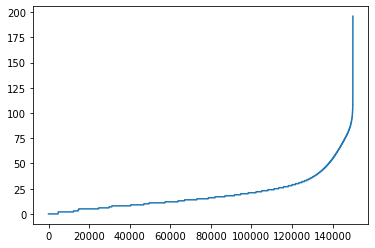

138264


In [10]:
sentence_len = [len(sentence) for sentence in train['tokens']]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=50) for l in sentence_len]))

In [11]:
train_Y = np.array([[i] for i in train['label']]) #np.asarray(train['label']).astype('float32')
train_Y

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [13]:
train_text_x = []
for sentence in train['tokens']:
    train_text_x.append([word[:5] for word in sentence.split()][:50])

train_text_x

[['짜증', '네요', '목소리'],
 ['포스터', '초딩', '영화', '오버', '연기', '가볍', '구나'],
 ['밓었다그래'],
 ['교도소', '이야기', '구먼', '재미', '평점', '조정'],
 ['사이몬페그',
  '익살',
  '스런',
  '연기',
  '돋보였',
  '영화',
  '스파이더맨',
  '보이',
  '커스틴',
  '던스트',
  '이뻐',
  '보였'],
 ['걸음마', '초등', '학교', '학년', '살용', '영화', 'ㅋㅋㅋ', '아까움'],
 ['원작', '긴장감', '살려', '못했'],
 ['반개',
  '아깝',
  '나온다',
  '이응경',
  '길용우',
  '연기',
  '생활',
  '인지',
  '해도',
  '그것',
  '보단',
  '납치',
  '감금',
  '반복',
  '반복',
  '드라마',
  '가족',
  '연기',
  '사람',
  '모엿'],
 ['액션', '는데', '재미', '영화'],
 ['평점', '건데', '한데', '헐리우드', '화려', '길들여져'],
 ['걍인피니트'],
 ['눈물나', '향수', '자극', '허진호', '감성', '절제', '멜로', '달인'],
 ['면서', '손들', '횡단', '보도', '건널', '뛰쳐나올', '이범수', '연기', '드럽', '못해'],
 ['담백', '깔끔', '해서', '신문', '기사', '잊어버린다', '사람', '다는'],
 ['취향', '존중', '한다지만', '내생', '극장', '영화', '감동', '스토리', '거지', '감동', '어거지'],
 ['긴장', 'ㅠㅠ'],
 ['사람',
  '웃긴',
  '바스코',
  '이기면',
  '락스',
  '라고',
  '바비',
  '이기',
  '아이돌',
  '라고',
  '깐다',
  '어서',
  '안달',
  '보인다'],
 ['굿바이', '레닌', '표절', '이해', '는데', '재미없'],
 ['이건', '깨알', '캐스팅', '질퍽'

In [14]:
print(len(train_text_x),len(train_Y))

150000 150000


In [15]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_text_x)
train_X = tokenizer.texts_to_sequences(train_text_x)
train_X = pad_sequences(train_X, padding='post')

print(train_X[:3])

[[ 87   3 375   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [241 340   1 973   7 530 168   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [16]:
print(len(train_X))

150000


In [17]:
for idx, word in enumerate(range(1,30), 1):
    print(idx, tokenizer.index_word[word])

1 영화
2 는데
3 네요
4 재밌
5 지만
6 ㅋㅋ
7 연기
8 최고
9 평점
10 어요
11 스토리
12 습니다
13 ㅋㅋㅋ
14 드라마
15 아니
16 생각
17 사람
18 감동
19 배우
20 만들
21 내용
22 감독
23 재미
24 시간
25 재미있
26 지루
27 재미없
28 쓰레기
29 사랑


In [18]:
len(train_X)

150000

In [19]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(train_X), 300, input_length=50), 
    tf.keras.layers.LSTM(units=128), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop', #optimizer='adam'
              loss='binary_crossentropy', #loss='sparse_categorical_crossentropy', 
              metrics=['acc']) #metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           45000000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 45,236,289
Trainable params: 45,236,289
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
444/938 [=============>................] - ETA: 3:31 - loss: 0.6936 - acc: 0.5004

KeyboardInterrupt: 

In [ ]:
print(type(train_X[0][0]), type(train_Y[0][0]))

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
#plt.ylim(0.7, 1)
plt.legend()

plt.show()